# AAut lab question 1 part 1
### Linear regression with outliers

 Import libraries

# Initial steps
Load libraries, load data, visual representations

In [343]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, RANSACRegressor

from sklearn.metrics import mean_squared_error

Load training data

In [344]:
# Importing the datasets
dataX = np.load('X_train.npy')
dataY = np.load('Y_train.npy')
testX = np.load('X_test.npy')

In [345]:
Q1 = np.quantile(dataY, 0.25)
Q3 = np.quantile(dataY, 0.75)
IQR = Q3 - Q1
outliers = dataY < (Q1 - 1.5 * IQR)
outliers = outliers | (dataY > (Q3 + 1.5 * IQR))

Plot the data for visual representation

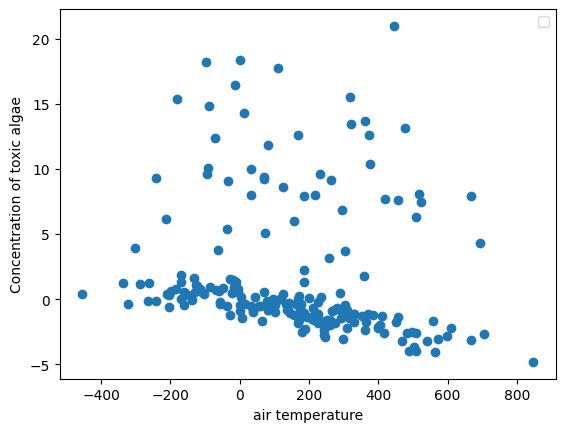

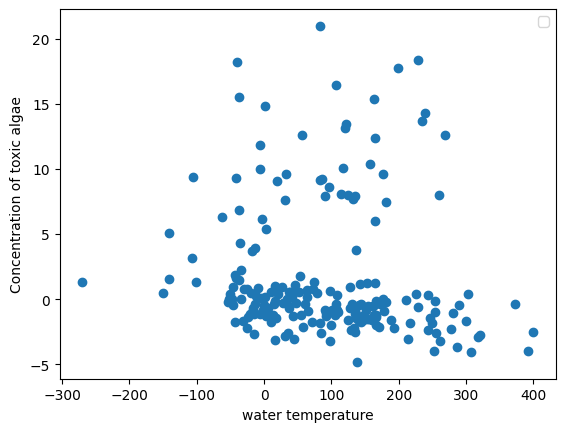

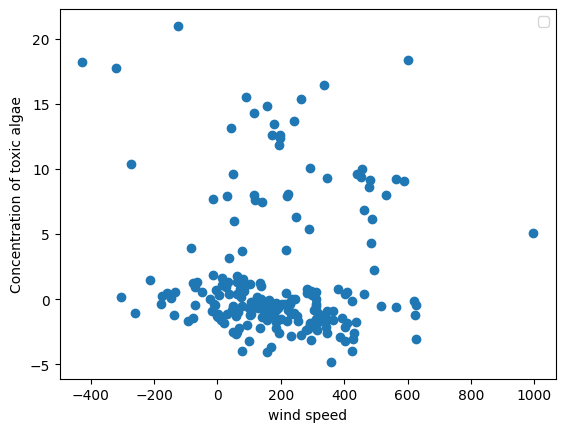

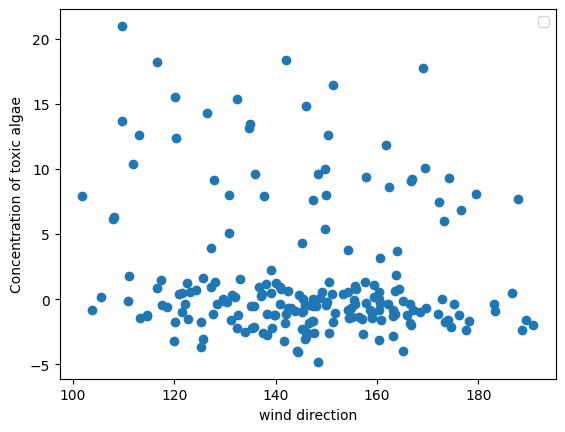

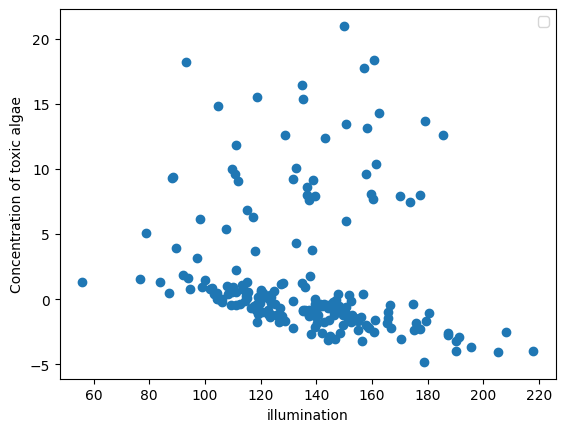

In [346]:
parameters = np.array(["air temperature", "water temperature", "wind speed", "wind direction", "illumination"])
for i in range(5):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.legend()
    plt.plot()
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")

# Important functions

Calculate SSE

In [347]:
def calculate_SSE(MSE, N):
  # Calculate the sum of squared errors
  SSE = MSE * N 
  return SSE

Create linear regression model

In [348]:
def create_model_LinearRegression(X, Y):
    # Create a linear regression model
    model = LinearRegression()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create Lasso model

In [349]:
def create_model_Lasso(X, Y):
    # Create a Lasso model
    model = LassoCV()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create Ridge model

In [350]:
def create_model_Ridge(X, Y):
    # Create a Ridge model
    model = RidgeCV()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create RANSAC model

In [351]:
def create_model_RANSACRegressor(X, Y):
    # Create a RANSACRegressor model
    model = RANSACRegressor()
    # Fit the model to the data
    model.fit(X, Y)
    return model

## Removal of outliers

In [352]:
def remove_outliers_x(X):
    max_mse = -1
    max_mse_index = -1
    for i in range(1, len(X)):
        print("x", X[i])
        print("x1", X[i-1])
        mse = (X[i] - X[i-1]) ** 2
        #print(mse)
        mse_index = np.argmax(mse)
        if mse[mse_index] > max_mse:
            max_mse = mse[mse_index]
            max_mse_index = i
    return max_mse_index

In [353]:
def remove_outliers(X, Y):
    num_points_to_remove = int(0.25 * len(Y))
    for _ in range(num_points_to_remove):
        model = LassoCV()
        model.fit(X, Y)
        predictions = model.predict(X)
        mse = (Y - predictions) ** 2
        max_mse_index = np.argmax(mse)
        if mse[max_mse_index] < 5:
            # max_mse_index = remove_outliers_x(X)
            break
        X = np.delete(X, max_mse_index, axis=0)
        Y = np.delete(Y, max_mse_index, axis=0)
    return X, Y

In [354]:
dataX_outliers, dataY_outliers = remove_outliers(dataX, dataY)

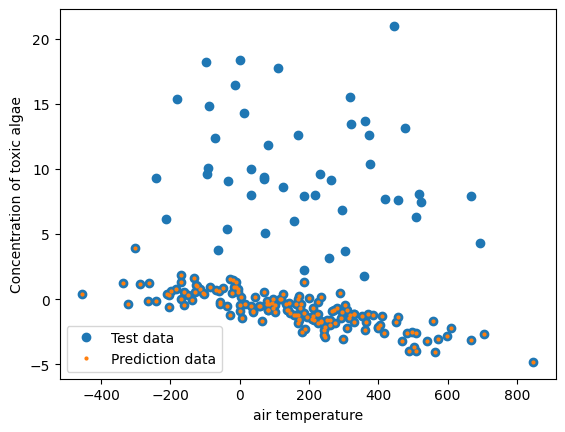

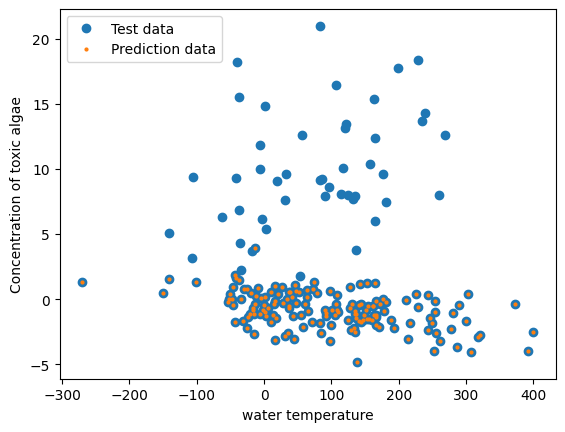

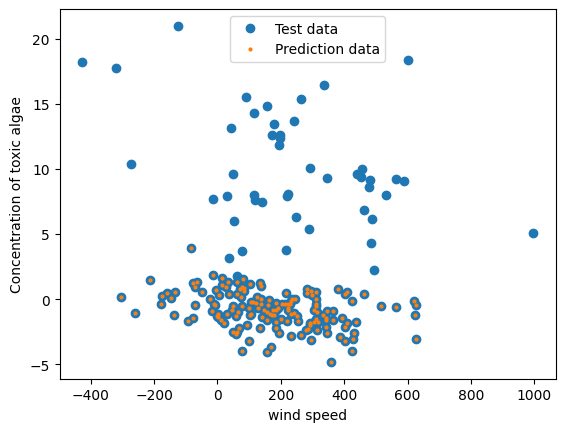

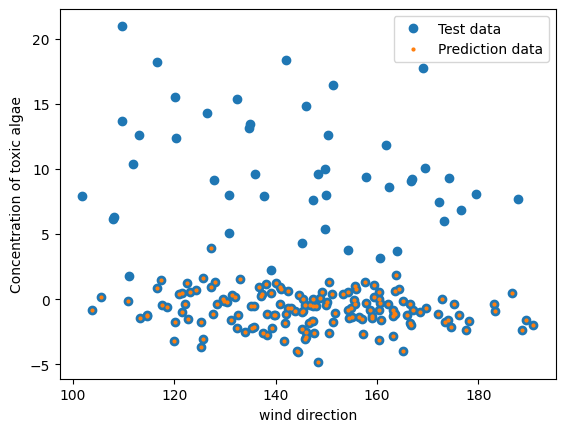

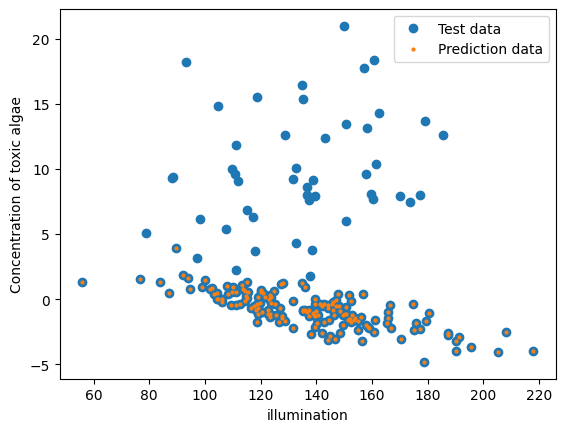

In [355]:
for i in range(5):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(dataX_outliers[:,i], dataY_outliers, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Test data", "Prediction data"])

In [356]:
# Create the models
model_LinearRegression = create_model_LinearRegression(dataX_outliers, dataY_outliers)
model_Lasso = create_model_Lasso(dataX_outliers, dataY_outliers)
model_Ridge = create_model_Ridge(dataX_outliers, dataY_outliers)
model_RANSACRegressor = create_model_RANSACRegressor(dataX_outliers, dataY_outliers)

# Predict the values for the test set
predY_LinearRegression = model_LinearRegression.predict(dataX_outliers)
predY_Lasso = model_Lasso.predict(dataX_outliers)
predY_Ridge = model_Ridge.predict(dataX_outliers)
predY_RANSACRegressor = model_RANSACRegressor.predict(dataX_outliers)

In [357]:
# Calculate Mean Squared Error (MSE)
mse_LinearRegression = mean_squared_error(dataY_outliers, predY_LinearRegression)
mse_Lasso = mean_squared_error(dataY_outliers, predY_Lasso)
mse_Ridge = mean_squared_error(dataY_outliers, predY_Ridge)
mse_RANSACRegressor = mean_squared_error(dataY_outliers, predY_RANSACRegressor)

In [358]:
# Calculate the sum of squared errors
SSE_LinearRegression = calculate_SSE(mse_LinearRegression, len(dataY))
print("SSE Linear Regression: ", SSE_LinearRegression)
SSE_Lasso = calculate_SSE(mse_Lasso, len(dataY))
print("SSE Lasso: ", SSE_Lasso)
SSE_Ridge = calculate_SSE(mse_Ridge, len(dataY))
print("SSE Ridge: ", SSE_Ridge)
SSE_RANSACRegressor = calculate_SSE(mse_RANSACRegressor, len(dataY))
print("SSE RANSACRegressor: ", SSE_RANSACRegressor)

SSE Linear Regression:  4.241222526676005
SSE Lasso:  4.337494100316481
SSE Ridge:  4.241318576664556
SSE RANSACRegressor:  4.4121088006062


Visualize model prediction

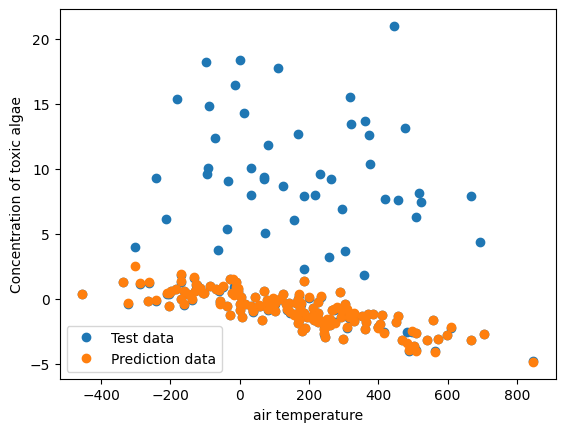

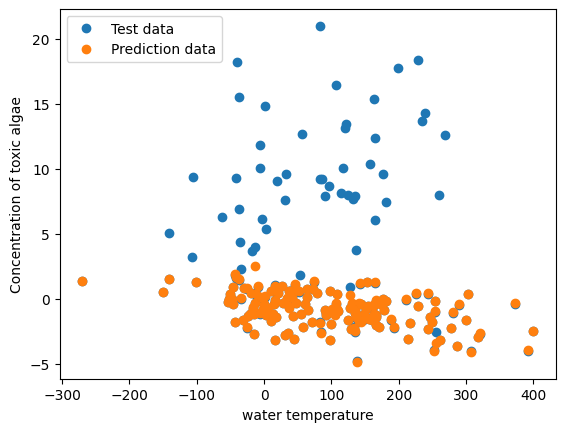

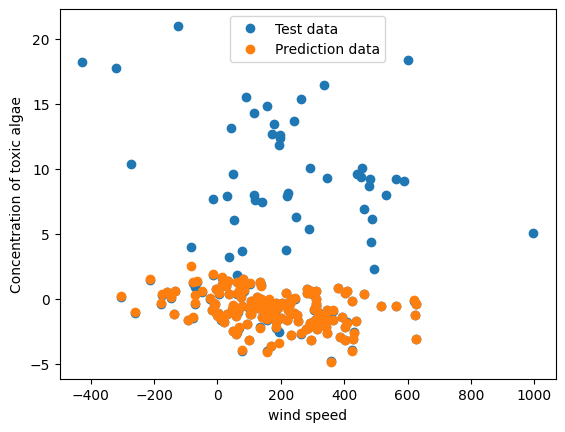

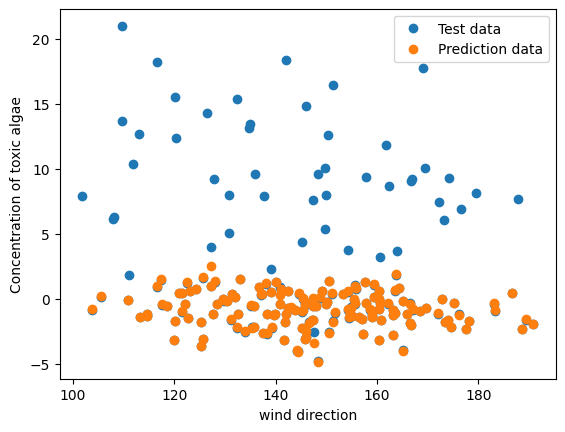

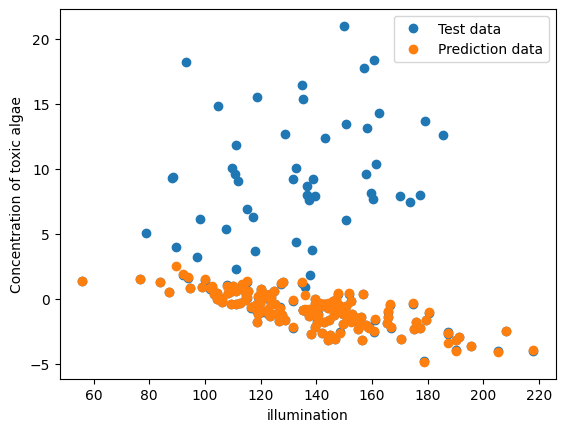

In [359]:
for i in range(5):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(dataX_outliers[:,i], predY_Ridge, 'o')
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Test data", "Prediction data"])